## Praca domowa 1, WUM 
* Autor: Piotr Nawrot
* Data: 11.03.2021

# Problem Portugalskiego banku i oferty lokat terminowych

* Celem zadania jest zbudowanie modelu, który na podstawie historycznych danych określi czy klient zechce założyć lokatę w naszym portugalskim banku.
* Od predykcji modelu będzie zależała strategia banku, na podstawie prawdopodobieństwa skorzystania z oferty przez potencjalnego klienta pracownicy banku będą decydować czy warto się z nim kontaktować.
    * Z tego powodu będziemy optymalizować metrykę ROC_AUC
* Dane użyte w poniższym notebooku są oparte o https://archive.ics.uci.edu/ml/datasets/bank+marketing 
    * Jedyna modyfikacja danych polega na tym, że zostało usunięte kilka kolumn celem utrudnienia zadania - w danych wyjściowo był dosyć duży leak, a mianowicie kolumna z czasem ostatniej rozmowy banku z klientem. 
    * Czas tej rozmowy miał bardzo dużą korelację z faktem założenia lokaty. 

## Wczytanie danych i zaimportowanie bibliotek, nic ciekawego

In [86]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns
sns.set(style="darkgrid")

import pandas as pd
import numpy as np
from collections import defaultdict

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [87]:
full_dataset = pd.read_csv('bank-classification.csv')
print(full_dataset.shape)
data_len = full_dataset.shape[0]

(41188, 15)


## Opis danych

* birth_date - self-explainable 
* job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired', 'self- employed','services','student','technician','unemployed','unknown') 
* marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed) 
* education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown') 
* default: has credit in default? (categorical: 'no','yes','unknown') 
* housing: has housing loan? (categorical: 'no','yes','unknown') 
* loan: has personal loan? (categorical: 'no','yes','unknown') 

* contact_date: ostatnia data kontaktu 
* contact: contact communication type (categorical: 'cellular','telephone') 

* campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact) 
* pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted) 
* previous: number of contacts performed before this campaign and for this client (numeric) 
* poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success') 

In [88]:
full_dataset.head()

,id,birth_date,job,marital,education,default,housing,loan,contact_date,contact,campaign,pdays,previous,poutcome,y
0,1,1952-03-23,housemaid,married,basic.4y,no,no,no,2008-05-12,telephone,1,999,0,nonexistent,no
1,2,1951-03-24,services,married,high.school,unknown,no,no,2008-05-26,telephone,1,999,0,nonexistent,unknown
2,3,1971-05-19,services,married,high.school,no,yes,no,2008-05-05,telephone,1,999,0,nonexistent,no
3,4,1968-01-24,admin.,married,basic.6y,no,no,no,2008-05-19,telephone,1,999,0,nonexistent,unknown
4,5,1952-05-11,services,married,high.school,no,no,yes,2008-05-19,telephone,1,999,0,nonexistent,unknown


### Data anylysis

Ciekawe obserwacje:
* Uczniowie i emeryci zakładają stosunkowo więcej lokat niż pozostali, ma to trochę sensu, Ci ludzie nie mają kredytów i losowych wydatków
* Osoby w związkach zakładają ciut mniej lokat niż single, możliwe, że wynika także z kredytów/wydatków na dzieci
* Jeśli ktoś ma problemy ze spłatą kredytu to raczej nie zakłada lokaty, to może być ważny czynnik
* Jeśli kontaktujemy się z kimś przez telefon komórkowy a nie stacjonarny to mamy większą szansę na wzięcie kredytu
* Jeśli ktoś wcześniej korzystał z usług banku, to na pewno warto do niego zadzwonić

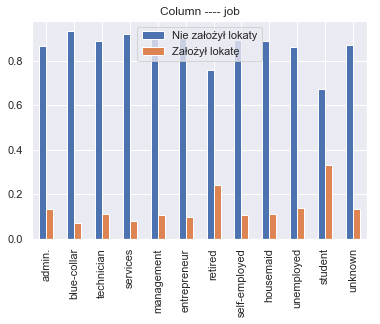

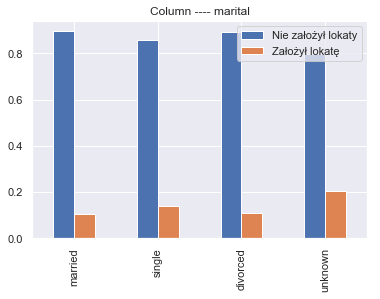

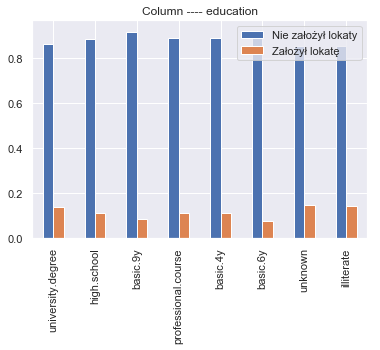

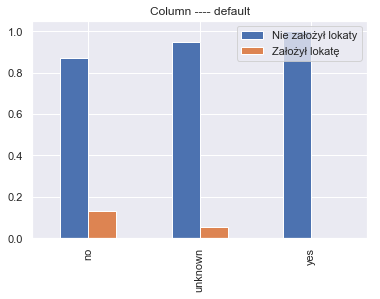

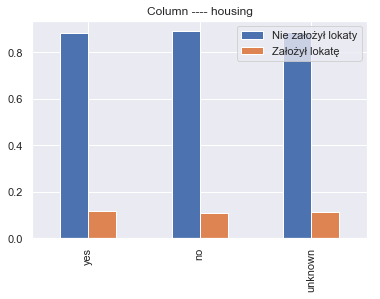

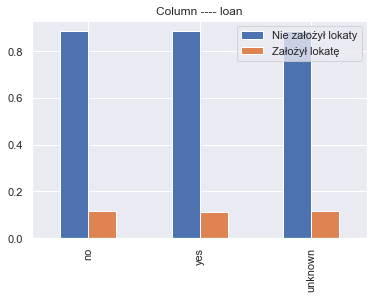

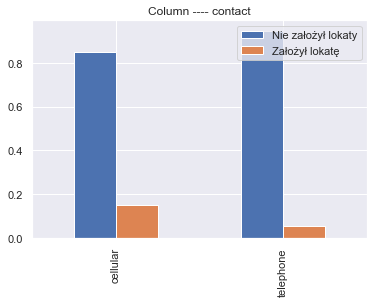

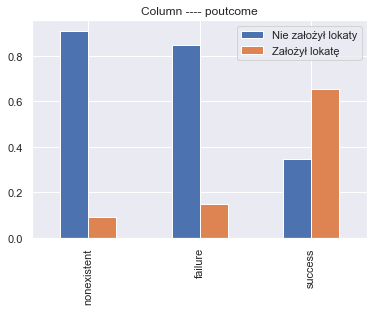

In [89]:
data = full_dataset.copy()

def plot_bar(column):
    df = pd.DataFrame()
    df['Nie założył lokaty'] = data[data['y'] == 'no'][column].value_counts()
    df['Założył lokatę'] = data[data['y'] == 'yes'][column].value_counts()
    df = df.div(df.sum(axis=1), axis=0)
    df.plot.bar(title = 'Column ---- {}'.format(column))
    plt.show()

for feature in ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']:
    plot_bar(feature)

* Spójrzmy jeszcze na wiek, skoro wcześniej zauważyliśmy że emeryci i studenci częściej biorą kredyty to powinno to się też potwierdzić pod kątem wieku
    * I rzeczywiście, potwierdza się

In [90]:
data = full_dataset.copy()
data['birth_date'] = pd.to_datetime(data['birth_date'])
data['contact_date'] = pd.to_datetime(data['contact_date'])
age = (data['contact_date'] - data['birth_date']).dt.days // 365

l = 0

def count_yes_ratio(mask):
    data_subset = data[mask]
    yes = (data_subset.y == 'yes').sum()
    no = (data_subset.y == 'no').sum()
    return yes / (yes + no)

for idx, quantile in enumerate([0.002, 0.03, 0.1, 0.4, 0.7, 0.96, 1]):
    r = int(age.quantile(quantile))
    mask = ((age > l) & (age <= r))
    score = count_yes_ratio(mask)
    print(f'Quantile of {quantile} equals to: {age.quantile(quantile)}. \n'  
            f'Score for this group eqauls to: {score} \n' + 
            f'Group contains of {mask.sum()} members. \n')
    l = r

Quantile of 0.002 equals to: 19.0. 
Score for this group eqauls to: 0.41818181818181815 
Group contains of 107 members. 

Quantile of 0.03 equals to: 24.0. 
Score for this group eqauls to: 0.1987281399046105 
Group contains of 1249 members. 

Quantile of 0.1 equals to: 28.0. 
Score for this group eqauls to: 0.1480637813211845 
Group contains of 3534 members. 

Quantile of 0.4 equals to: 35.0. 
Score for this group eqauls to: 0.10900095754867539 
Group contains of 12456 members. 

Quantile of 0.7 equals to: 45.0. 
Score for this group eqauls to: 0.0866067203028869 
Group contains of 12484 members. 

Quantile of 0.96 equals to: 58.0. 
Score for this group eqauls to: 0.09528565721134638 
Group contains of 9902 members. 

Quantile of 1 equals to: 97.0. 
Score for this group eqauls to: 0.3516042780748663 
Group contains of 1456 members. 



### Data preprocessing

* Pomimo tego, że poniższy data processing jest ogromny, to nie ma tutaj nic specjalnie wartego uwagi
* Wyciągnałem kilka featurów z daty kontaktu, takie jak miesiąc, rok, dzień miesiąca i tygodnia
* Wyciągnąłem wiek klienta
* Zmapowałem kategorie na inty żeby były odpowiednim wejściem do modelu w sposób mniej lub bardziej arbitralny

In [91]:
data = full_dataset.copy()
data['birth_date'] = pd.to_datetime(data['birth_date'])
data['contact_date'] = pd.to_datetime(data['contact_date'])

def calculate_age(data):
    data['age'] = (data['contact_date'] - data['birth_date']).dt.days // 365
    data['age'] = pd.qcut(data['age'], 5, labels=False, duplicates = 'drop')
    return data

data = calculate_age(data)

data['contact_year'] = data.contact_date.dt.year
data['contact_month'] = data.contact_date.dt.month
data['contact_day_of_month'] = data.contact_date.dt.day
data['contact_day_of_week'] = data.contact_date.dt.dayofweek

data['job_cat'] = data['job'].map({'admin.': 8,
                                    'blue-collar': 0,
                                    'entrepreneur': 2,
                                    'housemaid': 5,
                                    'management': 3,
                                    'retired': 10,
                                    'self-employed': 4,
                                    'services': 1,
                                    'student': 11,
                                    'technician': 6,
                                    'unemployed': 9,
                                    'unknown': 7}).astype('uint8')

data['marital_cat'] = data['marital'].map({'married': 0, 'divorced': 1, 'single': 2, 'unknown': 0}).astype('uint8')

data['education_cat'] = data['education'].map({'basic.6y': 0, 'basic.9y': 1, 'basic.4y': 2, 'professional.course': 3, 
                                               'high.school': 4, 'university.degree': 5, 'illiterate': 6, 'unknown': 4}).astype('uint8')

data['default_cat'] = data['default'].map({'no': 0, 'yes': 1, 'unknown': 1}).astype('uint8')

data['housing_cat'] = data['housing'].map({'no': 0, 'yes': 1, 'unknown': 1}).astype('uint8')

data['loan_cat'] = data['loan'].map({'no': 0, 'yes': 1, 'unknown': 0}).astype('uint8')

data['contact_cat'] = data['contact'].map({'telephone': 0, 'cellular': 1}).astype('uint8')

data['poutcome_cat'] = data['poutcome'].map({'nonexistent': 0, 'failure': 1, 'success': 2}).astype('uint8')

data['some_loan'] = ((data['loan_cat'] == 1) | (data['housing_cat'] == 1) | (data['default_cat'] == 1)).astype('uint8')

columns_to_onehot = []
data = pd.get_dummies(data, prefix=columns_to_onehot, columns=columns_to_onehot)

columns_to_drop = ['id', 'birth_date', 'contact_date'] + ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
data = data.drop(columns_to_drop, axis = 1)

np.random.seed(42)

train_set = data.copy()[data['y'] != 'unknown']
train_set.loc[:, 'y'] = train_set.y.map({'no':0.0, 'yes':1.0}).astype('float')

test_set = data.copy()[data['y'] == 'unknown'].drop('y', axis = 1)

X = train_set.copy().drop('y', axis = 1)
y = train_set.copy()['y'].to_numpy()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Spójrzmy na feature importance, może dowiemy się czegoś nowego

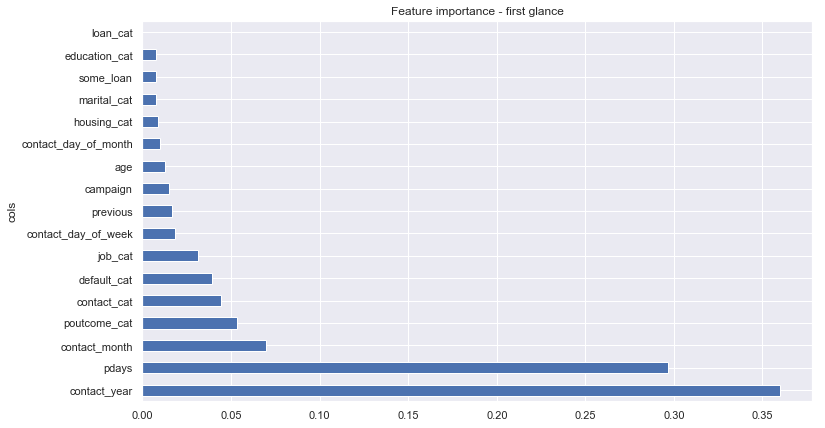

In [92]:
model = XGBClassifier()
model.fit(X, y)
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)
def plot_fi(fi, title=None): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False, title=title)
fi = rf_feat_importance(model, X)
plot_fi(fi[:25], title="Feature importance - first glance")

* Rok kontaktu ma ogromne znaczenie - rzeczywiście dane są z okresu 2008-2010
    * 2008 - 0.049353617598742947
    * 2009 - 0.19854343679556094
    * 2010 - 0.527643064985451
    * Albo rolę gra kryzys finansowy, albo bank uczy się na swoich błędach i udoskonala swoje metody
* Ogromne znaczenie mają też dane na temat poprzedniej kampanii - pdays i poutcome
* Dalej ważne były kategorie o których myśleliśmy na począktu takie jak forma kontaktu, czy problemy ze spłatą kredytu, ponad to jeszcze zatrudnienie
* Co ciekawe ważny jest też w tym wszystkim miesiąc kontaktu

In [93]:
def count_yes_ratio(mask):
    data_subset = data[mask]
    yes = (data_subset.y == 'yes').sum()
    no = (data_subset.y == 'no').sum()
    return yes / (yes + no)

for year in range(2008, 2011):
    print(year, count_yes_ratio(data['contact_year'] == year))

2008 0.049353617598742947
2009 0.19854343679556094
2010 0.527643064985451


Comparing to others people results on the leaderboard our model does preety good job

In [94]:
model = XGBClassifier()
print(cross_val_score(model, X, y, scoring='roc_auc', cv=cv).mean())

0.7902533464457305


In [ ]:
import scikitplot as skplt
import matplotlib.pyplot as plt

model = XGBClassifier()
model.fit(X, y)
y_true = y
y_probas = model.predict_proba(X)
skplt.metrics.plot_roc(y_true, y_probas)
plt.show()